In [172]:
import numpy as np
import math
import matplotlib.pyplot as plt 
from scipy import signal
from scipy import constants as const
from scipy import fftpack
from scipy import optimize
from iminuit import Minuit

In [203]:
""" Basic Parameters """
global samp  #sampleing frequency  (Hz)
global NET  # Noise Equivalent Temperature (uKsqrt(s))
global tau  # time constant of detector (s)
global tstop # measurement time (s)
global SNR # Signal to Noise Ratio

samp=  2000 
NET = 300 
tau =0.004
tstop = 5.
SNR = 5.0

""" stimulator part """
stm = np.array([1,2,4,5,10,20,40,50,75,80])
rflat = 1.0

In [204]:
def RecWOP(x,a,b):
    
    y = []

    y1 = [1.0/a/2*x[i]+0.5 for i in range(len(x)) if  x[i]<a]
    y.extend(y1)
    y2 = [1  for i in range(len(x)) if x[i]>=a and x[i]<=a+b]
    y.extend(y2)
    y3 = [1.0-1.0/a/2*(x[i]-a-b)  for i in range(len(x)) if x[i]>a+b and x[i]<3*a+b]
    y.extend(y3)
    y4 = [0   for i in range(len(x)) if x[i]>=3*a+b and x[i]<=3*a+2*b]
    y.extend(y4)
    y5 = [1.0/a/2*(x[i]-3*a-2*b) for i in range(len(x)) if x[i]>3*a+2*b and x[i]<=4*a+2*b]
    y.extend(y5)

    return y

def RecW(x,a,b,c):

    Nsp =  int(round(x[-1]*c))
    xsp = np.array((np.array_split(x, Nsp)))
    
    yRec  = []

    for i in range(Nsp):
        yOP = RecWOP(xsp[0],tilt,flat)
        yRec.extend(yOP)
        
    return yRec


In [205]:
def GetSignal(x,a,b,c):
    ys = RecW(x,a,b,c)
    xf = np.arange(0,len(ys)/samp,1.0/samp)

    yexp = np.exp(-xf/tau)/tau
    fft_exp = fftpack.fft(yexp)
    fft_sig = fftpack.fft(ys)
    
    in2 = fft_exp*fft_sig/samp
    signal =  fftpack.ifft(in2)
    
    return xf, signal.real + np.random.normal(0, 1.0/SNR, len(xf)) 

def GetOnePhase(x,a,b,c):
    
    Nsp =  int(round(x[-1]*c))
    xsp = np.array((np.array_split(x, Nsp)))
    
    ys = RecWOP(xsp[0],a,b)
    
    xf = np.arange(0,len(ys)/samp,1.0/samp)

    yexp = np.exp(-xf/tau)/tau
    fft_exp = fftpack.fft(yexp)
    fft_sig = fftpack.fft(ys)
    
    in2 = fft_exp*fft_sig/samp
    signal =  fftpack.ifft(in2)
    
    for i in range(Nsp):
        sigsum=signal.real+ np.random.normal(0, 1.0/SNR, len(xf))
    
    return xf, sigsum

def GetNoise(x,a,b,c):
    ys = RecW(x,a,b,c)
    xf = np.arange(0,len(ys)/samp,1.0/samp)
    
    return  xf, np.random.normal(0, 1.0/SNR, len(xf)) 



In [206]:
def FindPeak(x,y):
    fft_sig = fftpack.fft(y)
    freqList = fftpack.fftfreq(len(x), d=1.0/ samp)

    fft_sig = fftpack.fft(y)
    
    amp = np.sqrt(fft_sig.real**2+fft_sig.imag**2)/len(x)*2
    ph = np.arctan2(fft_sig.imag,fft_sig.real)

    #Peak Index
    maximal_idx = signal.argrelmax(amp, order=1)[0] 
    peak_cut = 0.01 #Peak threshold
    maximal_idx = maximal_idx[(amp[maximal_idx] > peak_cut) & (maximal_idx <= len(x)/2)]
    
    #print(max(amp[maximal_idx]), np.sqrt(max(amp[maximal_idx])))
    peak = max(amp[maximal_idx])

    return peak

def  plotFFT(x,y):
    fft_sig = fftpack.fft(y)
    freqList = fftpack.fftfreq(len(x), d=1.0/ samp)

    amp = np.sqrt(fft_sig.real**2+fft_sig.imag**2)/len(x)*2
    ph = np.arctan2(fft_sig.imag,fft_sig.real)

    #Peak Index
    maximal_idx = signal.argrelmax(amp, order=1)[0] 
    peak_cut = 0.01 #Peak threshold
    maximal_idx = maximal_idx[(amp[maximal_idx] > peak_cut) & (maximal_idx <= len(x)/2)]
    
    plt.plot(freqList,amp)
    plt.xlim(0,100)
    plt.yscale('log')

    

In [207]:
def rect(x,f,a,b,c,d,p1,p2,p3,p4,off):
    return  (4/const.pi)*(a*np.sin(2*const.pi*f*x+p1)+b*np.sin(2*const.pi*3*f*x+p2)+c*np.sin(2*const.pi*5*f*x+p3)+d*np.sin(2*const.pi*7*f*x+p4))+off

def Find1stPeak(x,y):
    pinit=[fstm,1,1/3,1/5,1/7,0,0,0,0,0.5]

    params,cov = optimize.curve_fit(rect, x, y, pinit)

    stderr = np.sqrt(np.diag(cov)) 
        
    return params[1]

def PlotSignal(x,y):

    pinit=[fstm,1,1/3,1/5,1/7,0,0,0,0,0.5]
    params,cov = optimize.curve_fit(rect, x, y, pinit)

    stderr = np.sqrt(np.diag(cov)) 
    
    plt.plot(x,y)
    plt.xlim(0,1)
    plt.plot(x, rect(x,params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7],params[8],params[9]))
    
def PlotNoise(x,y):

    plt.plot(x,y)

In [208]:
def MinuitMinimize(x,y):        
    
    def LSQ(f, a, b, c, d, p1, p2, p3, p4,off):
        yvar = 0.01
        return np.sum((y-rect(xf,f,a,b,c,d,p1,p2,p3,p4,off))**2/yvar**2)


    pinit = [fstm,0.5,1/3,1/5,1/7,0,0,0,0,0.5]
    perror=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]

    m = Minuit(LSQ, f=pinit[0], a=pinit[1], b=pinit[2], c=pinit[3], d=pinit[4], 
                 p1=pinit[5], p2=pinit[6], p3=pinit[7], p4=pinit[8], off=pinit[9],
                 error_f=perror[0], error_a=perror[1], error_b=perror[2], error_c=perror[3], error_d=perror[4],
                 error_p1=perror[5], error_p2=perror[6], error_p3=perror[7], error_p4=perror[8], error_off=perror[9], 
                 limit_a=(0, None), limit_b=(0, None), limit_c=(0, None), limit_d=(0, None),
               errordef=1)

    m.get_param_states()
    m.migrad()

    print(abs(m.values[1]))
    return abs(m.values[1])

def ShowFitResult(x,y):        
    pinit = [fstm,0.5,1/3,1/5,1/7,0,0,0,0,0.5]
    perror=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]

    m = Minuit(LSQ, f=pinit[0], a=pinit[1], b=pinit[2], c=pinit[3], d=pinit[4], 
                 p1=pinit[5], p2=pinit[6], p3=pinit[7], p4=pinit[8], off=pinit[9],
                 error_f=perror[0], error_a=perror[1], error_b=perror[2], error_c=perror[3], error_d=perror[4],
                 error_p1=perror[5], error_p2=perror[6], error_p3=perror[7], error_p4=perror[8], error_off=perror[9], 
                 limit_a=(0, None), limit_b=(0, None), limit_c=(0, None), limit_d=(0, None),
               errordef=1)
 
    #m.get_param_states()
    m.migrad()
    m.hesse()
    m.minos()
    print(m.get_param_states())


def PlotMinuitSignal(x,y):
    pinit = [fstm,0.5,1/3,1/5,1/7,0,0,0,0,0.5]
    perror=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]

    m = Minuit(LSQ, f=pinit[0], a=pinit[1], b=pinit[2], c=pinit[3], d=pinit[4], 
                 p1=pinit[5], p2=pinit[6], p3=pinit[7], p4=pinit[8], off=pinit[9],
                 error_f=perror[0], error_a=perror[1], error_b=perror[2], error_c=perror[3], error_d=perror[4],
                 error_p1=perror[5], error_p2=perror[6], error_p3=perror[7], error_p4=perror[8], error_off=perror[9], 
                 limit_a=(0, None), limit_b=(0, None), limit_c=(0, None), limit_d=(0, None),
               errordef=1)
    
    m.migrad()
        
    plt.plot(x,y)
    plt.plot(x, rect(x,m.values[0],m.values[1],m.values[2],m.values[3],m.values[4],m.values[5],m.values[6],m.values[7],m.values[8],m.values[9]))

In [212]:
def func(x,t,A):
    return  A/np.sqrt(1+(2*const.pi*t*x)**2)

def FitLPF(f,g1,g2,g3):
    #initial parameters 
    pinit=[tau, 1]

    params,cov = optimize.curve_fit(func, f, g1,pinit)
    params2, cov2 = optimize.curve_fit(func, f, g2,pinit)
    params3, cov3 = optimize.curve_fit(func, f, g3,pinit)

    print("MinuitFit = ", params,  "  diff=", (params[0]-tau)/tau)
    print("wave Fit = ",params2, "  diff=", (params2[0]-tau)/tau)
    print("FFT Fit = ",params3, "  diff=", (params3[0]-tau)/tau)



    plt.plot(f,g1/params[1],'o',label='Minuit')
    plt.plot(f,g2/params2[1],'o', label='wavefit')
    plt.plot(f,g3/params3[1],'o', label='FFT')

    plt.plot(f, func(f,params[0],params[1])/params[1], label='Minuit')
    plt.plot(f, func(f,params2[0],params2[1])/params2[1], label='wavefit')
    plt.plot(f, func(f,params3[0],params3[1])/params3[1], label='FFT')
    plt.legend()

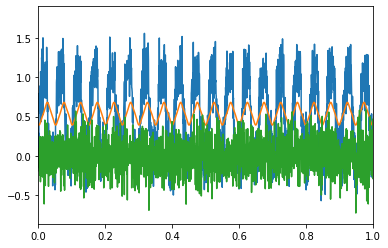

In [213]:
#gain = []
gain2 = []
gain3 = []

x = np.arange(0,tstop,1.0/samp)

for i in range(10):
    fstm = stm[i]
    flat = rflat/fstm/2
    tilt = (1-rflat)/4/fstm
    xf, y = GetSignal(x,tilt,flat,fstm)     
    xf, yvar = GetNoise(x,tilt,flat,fstm)     
  
    if i ==5:
        #PlotMinuitSignal(xf,y)
        PlotSignal(xf,y)
        PlotNoise(xf,yvar)
        #ShowFitResult(xf,y)
        #plotFFT(x,y)
    #gain.append(MinuitMinimize(xf,y))
    gain2.append(Find1stPeak(xf,y))
    gain3.append(FindPeak(xf,y))
    
f = stm
#g1= np.array(gain)
g2=np.array(gain2)
g3=np.array(gain3)

0.5352306578167589
0.5262326864060074
0.5290072833368185
0.5227312784824494
0.5459320600087911
0.4359272379363641
0.3269047648877035
0.34558684438427156
0.18964109273603702
0.23234044069430704


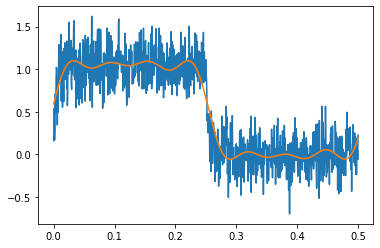

In [210]:
x = []
y = []
xf = []
gain = []

x = np.arange(0,tstop,1.0/samp)

for i in range(10):
    fstm = stm[i]
    flat = rflat/fstm/2
    tilt = (1-rflat)/4/fstm
    xf, y = GetOnePhase(x,tilt,flat,fstm)     
    #xf, yerror = GetNoise(x,tilt,flat,fstm)     
    
    if i ==1:
        PlotMinuitSignal(xf,y)
        #ShowFitResult(xf,y)
        #plotFFT(x,y)
    gain.append(MinuitMinimize(xf,y))
    
f = stm
g1= np.array(gain)

MinuitFit =  [0.0046126  0.53409062]   diff= 0.15314884914248622
wave Fit =  [0.01952553 0.57678753]   diff= 3.8813835179634713
FFT Fit =  [0.0039179  0.67847881]   diff= -0.02052481989105962


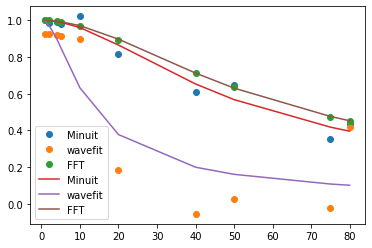

In [211]:
FitLPF(f,g1,g2,g3)

In [332]:
result1=[[1.0008336293521243,0.8644990198108536,0.8886542490292865,0.8959985509146158,1.0268612256504333,0.8924319097018256],
         [0.07253664918692396, -0.005714394661179498, -0.007812778114588657, 0.005501607730967924, 0.011424747255616222, 0.009518846114210493],
         [0.043979508092483084,0.038544269578102974,0.0312769403362256,0.02304063135559111,0.010876401481221647,0.012577430575168476],
         [0.2456002309750566,0.06418054622734387,0.013022980456657562,0.015368353607079013,0.007714361826994913, 0.011185223615795686]]

result2 = [[-0.00730660833397935,0.008908708666239759,0.001059945946427221,-0.017123669606045056,-0.013518178907162906,-0.010873744968803098],[-0.04600475873088681,-0.014648853396649793,-0.019133301175467375,-0.00564086745231708,7.628392831009884e-05,-0.001481988968441393],[-0.051311793821275965,-0.011123874373461864,0.02235638779609188,0.013402145375744808,8.265890623099931e-05,0.0019458613958111756],[-0.12801446919045062,-0.003692593481976515, 0.001303046334786076, 0.006756090690608445, -0.0031524644900724624,0.0006445966255048952]]

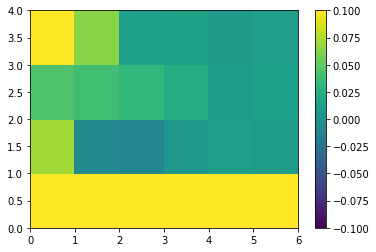

In [333]:
#X = [1,2,5,10,20,50]
#Y = [1.0, 0.8,0.5,0.2]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.pcolor(result1, vmin=-0.1, vmax=0.1)
plt.colorbar()

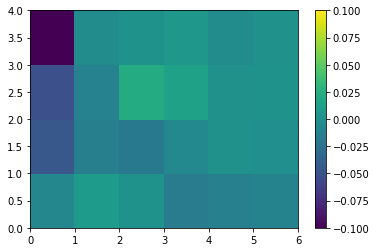

In [334]:
#xlabel = [1,2,5,10,20,50]
#ylabel = [1.0, 0.8,0.5,0.2]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.pcolor(result2, vmin=-0.1, vmax=0.1)
plt.colorbar()